In [ ]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/")
os.getcwd()

'/content/gdrive/My Drive/Colab Notebooks'

In [ ]:
#Default dimensions we found online
img_width, img_height = 224, 224 
 
#Create a bottleneck file
top_model_weights_path = "bottleneck_fc_model.h5"
# loading up our datasets

path1 = "/content/gdrive/My Drive/Colab Notebooks/train_data_dir"
path2 = "/content/gdrive/My Drive/Colab Notebooks/validation_data_dir"
path3 = "/content/gdrive/My Drive/Colab Notebooks/test_data_dir"
train_data_dir = path1 
validation_data_dir = path2
test_data_dir = path3 
 
# number of epochs to train top model 
epochs = 7 #this has been changed after multiple model run 
# batch size used by flow_from_directory and predict_generator 
batch_size = 50 

In [ ]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet')
datagen = ImageDataGenerator(rescale=1. / 255) 
#needed to create the bottleneck .npy files

In [ ]:
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_train_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
 
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train) 
 
np.save("bottleneck_features_train.npy", bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ("Time:", elapsed)

Found 2056 images belonging to 10 classes.
Time: 0:18:48.308803


In [ ]:
#training data
generator_top = datagen.flow_from_directory( 
   train_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
train_data = np.load("bottleneck_features_train.npy") 
 
# get the class labels for the training data, in the original order 
train_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 2056 images belonging to 10 classes.


In [ ]:
#validation data
generator_top1 = datagen.flow_from_directory( 
   validation_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_validation_samples = len(generator_top1.filenames) 
num_classes1 = len(generator_top1.class_indices) 
 
# load the bottleneck features saved earlier 
validation_data = np.load("bottleneck_features_train.npy") 
 
# get the class labels for the validation data, in the original order 
validation_labels = generator_top.classes 
 
# convert the validation labels to categorical vectors 
validation_labels = to_categorical(validation_labels, num_classes=num_classes1)

Found 399 images belonging to 10 classes.


In [ ]:
#test data
generator_top2 = datagen.flow_from_directory( 
   test_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_test_samples = len(generator_top2.filenames) 
num_classes2 = len(generator_top2.class_indices) 
 
# load the bottleneck features saved earlier 
test_data = np.load("bottleneck_features_train.npy") 
 
# get the class labels for the test data, in the original order 
test_labels = generator_top.classes 
 
# convert the test labels to categorical vectors 
test_labels = to_categorical(test_labels, num_classes=num_classes2)

Found 10 images belonging to 10 classes.


In [ ]:
start = datetime.datetime.now()
model = Sequential() 
model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.5)) 
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation="softmax"))
model.compile(loss="categorical_crossentropy",
   optimizer=optimizers.RMSprop(lr=1e-4),
   metrics=["acc"])
history = model.fit(train_data, train_labels, 
   epochs=7,
   batch_size=batch_size, 
   validation_data=(validation_data, validation_labels))
model.save_weights(top_model_weights_path)
(eval_loss, eval_accuracy) = model.evaluate( 
    validation_data, validation_labels, batch_size=batch_size,verbose=1)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss))
end= datetime.datetime.now()
elapsed= end-start
print ("Time:", elapsed)

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 2056 samples, validate on 2056 samples
Epoch 1/7
2056/2056 [==============================] - 2s 1ms/step - loss: 2.0345 - acc: 0.2977 - val_loss: 1.4649 - val_acc: 0.5423
Epoch 2/7
2056/2056 [==============================] - 2s 923us/step - loss: 1.4273 - acc: 0.5287 - val_loss: 1.0322 - val_acc: 0.7130
Epoch 3/7
2056/2056 [==============================] - 2s 912us/step - loss: 1.1664 - acc: 0.6143 - val_loss: 0.9300 - val_acc: 0.7160
Epoch 4/7
2056/2056 [==============================] - 2s 928us/step - loss: 0.9771 - acc: 0.6829 - val_loss: 0.6266 - val_acc: 0.8536
Epoch 5/7
2056/2056 [==============================] - 2s 913us/step - loss: 0.8669 - acc: 0.7140 - val_loss: 0.5410 - val_acc: 0.8541
Epoch 6/7
2056/2056 [==============================] - 2s 912us/step - loss: 0.7738 - acc: 0.7490 - val_loss: 0.7448 - val_acc: 0.7194
Epoch 7/7
2056/2056 [==============================] - 0s 172us/step
[INFO] accuracy: 91.25%
[INFO] Loss: 0.3811810885008845
Time: 0:00:14.40079

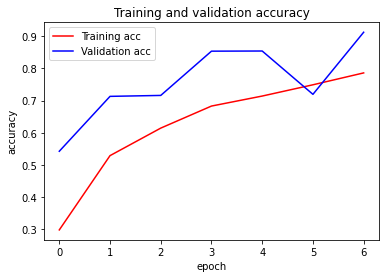

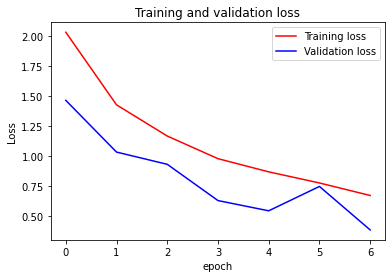

In [ ]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))
plt.plot(epochs, acc, "r", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.ylabel("accuracy") 
plt.xlabel("epoch")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.ylabel("Loss") 
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_data,test_labels)

2056/2056 [==============================] - 0s 229us/step


[0.38118109440409254, 0.9124513864517212]

In [ ]:
preds = np.round(model.predict(test_data),0)
print("rounded test_labels",preds)

rounded test_labels [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
animals=['Cat','Chicken','Cow','Dog','Elephant','Horse','sheep','Spider','Squirrel','Butterfly']
classification_matrics = metrics.classification_report(test_labels, preds,target_names=animals)
print(classification_matrics)

              precision    recall  f1-score   support

         Cat       1.00      0.94      0.97       200
     Chicken       0.98      0.86      0.91       209
         Cow       1.00      0.84      0.91       200
         Dog       1.00      0.51      0.68       204
    Elephant       0.92      0.90      0.91       220
       Horse       0.98      0.94      0.96       200
       sheep       0.91      0.93      0.92       223
      Spider       0.97      0.20      0.33       200
    Squirrel       0.98      0.94      0.96       200
   Butterfly       0.99      0.83      0.90       200

   micro avg       0.97      0.79      0.87      2056
   macro avg       0.97      0.79      0.84      2056
weighted avg       0.97      0.79      0.85      2056
 samples avg       0.79      0.79      0.79      2056



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
